**The goal of this exercise is to implement a Decision Tree and Logistic regression model that can predict the electicity levels i.e. peak and offpeak (high /low) in an energy network.**

At the end of the exercise, you should be able to :
- Implement a Decision Tree algorithm for classification of data using scikit-learn
- Implement a Logistric Regression model for classification of data using scikit-learn
- Investigate and understand the impact of different parameters on the classification accuracy
- Compare the performance of the DT and LR algorithms

- **<span style="color:red">It is highly recommended that you install a virtual environment to avoid conflicts with other packages. To install the latest version in a new virtual environment, run:</span>**

In [1]:
# >> conda create --name 'my_env_name' python matplotlib spyder pandas scipy numpy mkl jupyter ipython scikit-learn
# >> conda activate 'my_env_name'

In [1]:
import random 
import numpy as np
import pandas as pd
import os
import sys
import matplotlib.pyplot as plt
import math

import sklearn
import datetime as dt
import time

In [2]:
# Helper function to plot the decision boundary for the case of ONLY two features

#If you do not have the seaborn package is not installed run :>> conda install seaborn at the command prompt

from sklearn.inspection import DecisionBoundaryDisplay
from matplotlib.colors import ListedColormap
import seaborn as sns

def plot_Decion_boundary(model, features, targets):
    
    # Create color maps
    cmap_light = ListedColormap(["lightyellow","lightblue"])
    cmap_bold = ["darkorange", "blue"]

    _, ax = plt.subplots()
    DecisionBoundaryDisplay.from_estimator(
        model,
        features,
        cmap=cmap_light,
        ax=ax,
        response_method="predict",
        plot_method="pcolormesh",
        shading="auto",
    )

    # Plot the training/test points
    sns.scatterplot(
        x=features.iloc[:, 0],
        y=features.iloc[:, 1],
        hue=targets,
        palette=cmap_bold,
        alpha=0.5,
        edgecolor="black",
    )
    
    plt.show()

- **<span style="color:black">Load and process the different datasets</span>**

In [3]:
#Prediction period
t_s = pd.Timestamp(dt.datetime(2019, 1, 1, 0, 0, 0), tz='UTC')
t_e = pd.Timestamp(dt.datetime(2021, 12, 31, 23, 0, 0), tz='UTC')

Weather data

In [4]:
path = os.path.join(os.getcwd(),'WeatherData.csv')
df_w = pd.read_csv(path)
df_w["PeriodStart"] = pd.to_datetime(df_w["PeriodStart"], utc=True)
df_w.rename(columns = {'PeriodStart':'HourUTC'}, inplace = True)

# Filter, sort and reindex
df_w = df_w.loc[(df_w['HourUTC']>=t_s) & (df_w['HourUTC']<=t_e)].reset_index(drop=True)

Retail Price data


In [5]:
price_path = os.path.join(os.getcwd(),'Prices.csv')
df_price = pd.read_csv(price_path)
df_price["HourUTC"] = pd.to_datetime(df_price["HourUTC"], utc=True)

#Sort based on selected period
df_price = df_price.loc[(df_price['HourUTC']>=t_s) & (df_price['HourUTC']<=t_e)].reset_index(drop=True)

Consumption data

In [6]:
consump_path = os.path.join(os.getcwd(),'ConsumptionDE35Hour19_21.csv')
df_consmp = pd.read_csv(consump_path)
df_consmp["HourUTC"] = pd.to_datetime(df_consmp["HourUTC"], utc=True)


#Filter based on selected period, consumer type and price area
df_consmp = df_consmp.loc[(df_consmp['HourUTC']>=t_s) & (df_consmp['HourUTC']<=t_e)].reset_index(drop=True)
df_consmp = df_consmp[df_consmp['PriceArea']=='DK1'].reset_index(drop=True)
df_consmp = df_consmp[df_consmp['ConsumerType_DE35']== 112].reset_index(drop=True)

#Add time of day and week day to dataset
df_consmp['Weekday'] = df_consmp['HourUTC'].dt.weekday #Add Weekday to the dataset
df_consmp['Hour'] = df_consmp['HourUTC'].dt.hour #Add Weekday to the dataset


In [7]:
#Ensure all datasets are the same size
assert df_consmp.shape[0]==df_price.shape[0]==df_w.shape[0]

### Tasks

### Task 1: Categorize the data and choose the descriptive features to be considered.

In [8]:
#Categorise the load consumption based on the threshold
cons = df_consmp.TotalCon.quantile(0.75) 
df_consmp['Con_HiLo'] = df_consmp['TotalCon'].apply(lambda x: 'High' if x >= cons  else 'Low')

In [9]:
# create dataset of features and targets
data = pd.concat([df_consmp['HourUTC'],df_consmp['Con_HiLo'], df_consmp['Weekday'], df_consmp['Hour'], df_price['l_b_spot'], df_w['AirTemp']], axis=1) 


In [ ]:
#data

#### 1.1  Choose the descriptive features for your classification problem

In [10]:
#Choose the descriptive features for your classification problem
features_names =['l_b_spot','AirTemp'] # Descriptive features
features = data[features_names] 
targets = data['Con_HiLo']       #Target 

#### 1.2 Split the data into a training and a testing set

In [11]:
# select and hold 80% of all data used for training and remaining 20% of data used for testing
nr_samples = len(data)
train_size = int(np.rint(0.8 * nr_samples))
train_features = features.iloc[:train_size]
test_features = features.iloc[train_size:]

train_targets = targets.iloc[:train_size] 
test_targets = targets.iloc[train_size:]

In [ ]:
# Using the inbuilt function, the train-test split can be done by randomly selecting indices

#from sklearn.model_selection import train_test_split
#train_features , test_features , train_targets , test_targets  = train_test_split(features, targets, test_size=0.2, random_state=18)

### Task 2 : Build and evaluate a decision tree classifier using Sklearn

#### 2.1  Create a classification model to train a DT.

In [12]:
#Write a function to train a classification model and provide predictions
def classifier(model, train_features,train_targets,test_features):
    """
     model: selected classification model
     train_features: features to train model 
     train_targets : labels for model training
     test_features: features to test model
    """ 
   
    #Model selection 
    clf = model
    
    #Train the model
    clf.fit(train_features,train_targets)

    #Predict the labels of new, unseen data
    prediction = clf.predict(test_features)
    
    return prediction, clf

In [24]:
#Train a decision tree classifier
from sklearn.tree import DecisionTreeClassifier

#Model confguration
DT_model = DecisionTreeClassifier(max_depth=10,         #Maximium tree depth used in pre-prunning
                                  criterion="entropy", #entropy # Loss function entropy
                                  random_state=42) 


DT_prediction, DT_clf = classifier(DT_model, train_features,train_targets,test_features)



In [ ]:
# plot decision tree
#from sklearn import tree
#tree.plot_tree(DT_clf)

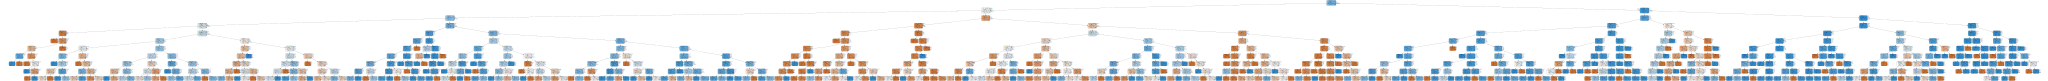

In [25]:
#View decision tree as graph
#You need to install the graphviz module: conda install python-graphviz

import graphviz 
import matplotlib.image as plt_img
from IPython.display import Image
from sklearn import tree

dot_data = tree.export_graphviz(DT_clf, out_file="decision_tree.dot", 
                                feature_names=features_names,
                                class_names=['High', 'Low'],
                                filled=True, rounded=True,  
                                special_characters=True) 

graph = graphviz.Source.from_file("decision_tree.dot")

graph

#### 2.2  Evaluate the accuracy of your model.

In [26]:
# Using the predictions from your test data, calculate the performance of the decision tree classifier. 

def model_performance(targets, predictions):
    
    """
     predictions: model predictions
     targets: true values
    """     
    Accuracy, MCC  = 0.0 , 0.0
    #Calculate the different parameters of the confusion matrix
    
    FP = len([x for x,y in zip(targets,predictions) if (x == "Low" and y == "High")])

    FN = len([x for x,y in zip(targets,predictions) if (x == "High" and y == "Low")])
    
    TP = len([x for x,y in zip(targets,predictions) if (x == "High" and y == "High")])
    
    TN = len([x for x,y in zip(targets,predictions) if (x == "Low" and y == "Low")])
    
    #Calculate the Accuracy
    
    Accuracy = (TN + TP) / (TN + TP + FN + FP)
    
    #Calculate the MCC Score
    
    MCC = (TP*TN - FP*FN) / ((TP+FP)*(TP+FN)*(TN+FP)*(TN+FN))**(1/2)
    
    return Accuracy, MCC

print(model_performance(test_targets, DT_prediction)) 



(0.8794905911423684, 0.7002951958275417)


- **<span style="color:blue">Compare the accuracy of your model on the training data and test data.</span>**

In [27]:
#The metrics are also available from sckit learn using the following codes, compare with your values above

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, matthews_corrcoef
print('DT accuracy: ', accuracy_score(test_targets, DT_prediction))
print('DT confusion matrix: \n', confusion_matrix(test_targets, DT_prediction))
print('DT MCC Score: ', matthews_corrcoef(test_targets, DT_prediction))


DT accuracy:  0.8794905911423684
DT confusion matrix: 
 [[1057  139]
 [ 495 3570]]
DT MCC Score:  0.7002951958275417



- **<span style="color:blue">Compare the accuraccy and MCC score performance metrics and MCC score. What is the reason behind the discrepancy if any?</span>**


- **<span style="color:blue">Which is the most sufficient metric to evaluate the model? Why do you think so?.</span>**

- **<span style="color:blue">Make changes to the hyperparameters i.e. max_depth, how does this affect the model performance? </span>**



- **<span style="color:blue">Is it possible to have a tree with fewer nodes than you chose and still describe obtain the same accuracy? (Prunning)</span>**

### Task 3:  Train and evaluate an LR classification model and compare the model performance of DT and LR classifiers.

In [28]:
#Train the clasification model with LR
from sklearn.linear_model import LogisticRegression

#Model confguration
LR_model = LogisticRegression(penalty='l2', #options 'l1', 'l2', 'elasticnet'
                              max_iter = 500,
                              solver = 'saga' # do not change this 
                             )

LR_prediction, LR_clf = classifier(LR_model, train_features,train_targets,test_features)

In [31]:
print('DT accuracy: ', accuracy_score(test_targets, LR_prediction))
print('DT confusion matrix: \n', confusion_matrix(test_targets, LR_prediction))
print('DT MCC Score: ', matthews_corrcoef(test_targets, LR_prediction))

DT accuracy:  0.8756890325033264
DT confusion matrix: 
 [[1048  148]
 [ 506 3559]]
DT MCC Score:  0.6906341705676466


- **<span style="color:blue">Compare the accuracy of your model on the training data and test data. </span>**

- **<span style="color:blue">Compare the accuracy of the decision tree and logistic regression classifiers.</span>**

- **<span style="color:blue"> When should you use logistic regression instead of a decision tree for a classification problem? Hint: Recall that LR is a linear classifier. Use the helper function to have a plot of your decision boundary.</span>**


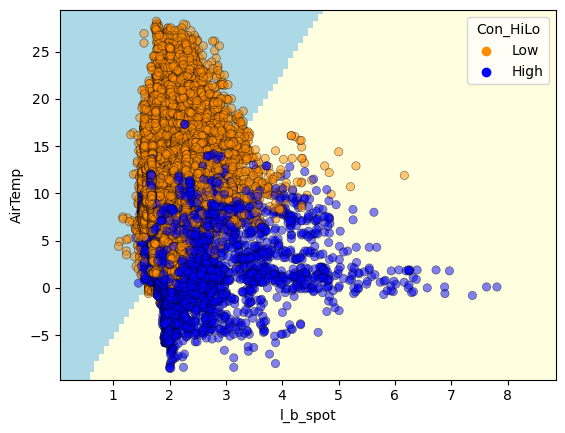

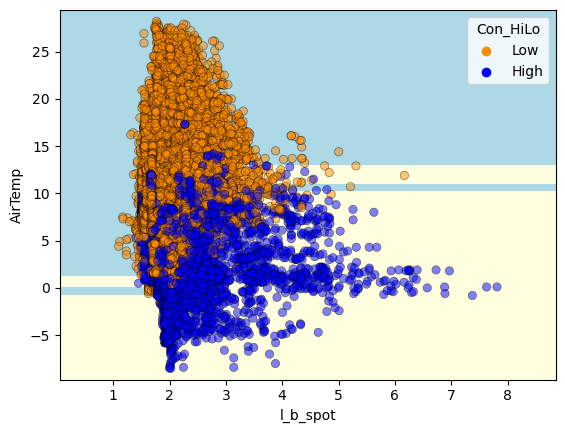

In [34]:
plot_Decion_boundary(LR_clf, features, targets)

plot_Decion_boundary(DT_clf, features, targets)

- **<span style="color:blue">For both DTs and LR, what is the effect that the choice of their respective hyperpameters have on classification accuracy.</span>**

- **<span style="color:blue">Varry the amount of training and test data, how is your accuracy affected with more or less data?</span>**

- **<span style="color:blue">Experiment with different datasets i.e. consider different combinations of features or even a third, fourth.. descriptive feature and evaluate the performance of the model.</span>**